In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20, 20)
import requests
import pandas as pd
import geopandas as gpd

In [17]:
"""
You need an authorization key, I got a trial one by mailing: DBOpenData@deutschebahn.com
For real stuff I think you have to register: 

Für einen eigenen API-Key bitte im Developer-Portal registrieren: https://developer.deutschebahn.com/store/getting-started 
Und die Fahrplan-API abonnieren: https://developer.deutschebahn.com/store/apis/info?name=Fahrplan&version=v1&provider=DBOpenData

"""

#My local key:
with open('DB_API_key.txt','r') as file:
    API_Key =  file.readline()

In [18]:
params = {}
params['lang'] = 'en'
params['authKey'] = API_Key
params['input'] = 'Düsseldorf Hbf'
params['format'] ='json'
r = requests.get('https://open-api.bahn.de/bin/rest.exe/location.name',params = params)
result = r.json()
station = result['LocationList']['StopLocation'][0]
station

{'id': '008000085',
 'lat': '51.219960',
 'lon': '6.794317',
 'name': 'Düsseldorf Hbf'}

In [19]:

params = {}
params['lang'] = 'en'
params['authKey'] = 'DBhackFrankfurt0316'
params['id'] = station['id']
params['date'] = '2017-10-14'
params['time'] = '20%0a30'
params['format'] ='json'
r = requests.get('https://open-api.bahn.de/bin/rest.exe/departureBoard',params = params)
result = r.json()
departure_board = result['DepartureBoard']['Departure']

In [20]:
df_departure_board = pd.DataFrame(departure_board)
df_departure_board.get_value(0,'JourneyDetailRef')

{'ref': 'https://open-api.bahn.de/bin/rest.exe/v1.0/journeyDetail?ref=190425%2F80430%2F914610%2F393830%2F80%3Fdate%3D2017-10-14%26station_evaId%3D8000085%26station_type%3Ddep%26authKey%3DDBhackFrankfurt0316%26lang%3Den%26format%3Djson%26'}

In [21]:
df_departure_board = pd.DataFrame(departure_board)
df_departure_board

,JourneyDetailRef,date,direction,name,stop,stopid,time,track,tyoe,type,tyte
0,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Köln Hbf,ICE 846,Düsseldorf Hbf,8000085,20:08,16,NaN,ICE,NaN
1,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Dortmund Hbf,EC 114,Düsseldorf Hbf,8000085,20:11,18,NaN,EC,NaN
2,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Karlsruhe Hbf,ICE 605,Düsseldorf Hbf,8000085,20:18,16,NaN,ICE,NaN
3,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Frankfurt(Main)Hbf,IC 2315,Düsseldorf Hbf,8000085,20:27,16,NaN,IC,NaN
4,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Dortmund Hbf,ICE 514,Düsseldorf Hbf,8000085,20:33,18,NaN,ICE,NaN
5,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Hamburg Hbf,ICE 26,Düsseldorf Hbf,8000085,20:39,NaN,NaN,ICE,NaN
6,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Frankfurt(Main)Hbf,ICE 221,Düsseldorf Hbf,8000085,20:48,16,NaN,ICE,NaN
7,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Wien Hbf (Autoreisezuganlage),EN 40421,Düsseldorf Hbf,8000085,20:54,19,EN,NaN,NaN
8,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Innsbruck Hbf,EN 421,Düsseldorf Hbf,8000085,20:54,19,NaN,EN,NaN
9,{'ref': 'https://open-api.bahn.de/bin/rest.exe...,2017-10-14,Köln Hbf,ICE 544,Düsseldorf Hbf,8000085,21:08,16,NaN,ICE,NaN


In [22]:
"""Correcting some errors in the API output"""
def merge_cols(df,target_col,other_col):
    if other_col in df:
        df[target_col] = df[target_col].fillna(df[other_col])
        df.drop(other_col,axis = 1,inplace = True)    
 
merge_cols(df_departure_board,'type','tyte')
merge_cols(df_departure_board,'type','tyoe')


In [23]:
df_departure_board.to_csv('departure_board.csv',sep = ';')

In [24]:
df_departure_board.ix[:,df_departure_board.columns != 'JourneyDetailRef']

,date,direction,name,stop,stopid,time,track,type
0,2017-10-14,Köln Hbf,ICE 846,Düsseldorf Hbf,8000085,20:08,16,ICE
1,2017-10-14,Dortmund Hbf,EC 114,Düsseldorf Hbf,8000085,20:11,18,EC
2,2017-10-14,Karlsruhe Hbf,ICE 605,Düsseldorf Hbf,8000085,20:18,16,ICE
3,2017-10-14,Frankfurt(Main)Hbf,IC 2315,Düsseldorf Hbf,8000085,20:27,16,IC
4,2017-10-14,Dortmund Hbf,ICE 514,Düsseldorf Hbf,8000085,20:33,18,ICE
5,2017-10-14,Hamburg Hbf,ICE 26,Düsseldorf Hbf,8000085,20:39,NaN,ICE
6,2017-10-14,Frankfurt(Main)Hbf,ICE 221,Düsseldorf Hbf,8000085,20:48,16,ICE
7,2017-10-14,Wien Hbf (Autoreisezuganlage),EN 40421,Düsseldorf Hbf,8000085,20:54,19,EN
8,2017-10-14,Innsbruck Hbf,EN 421,Düsseldorf Hbf,8000085,20:54,19,EN
9,2017-10-14,Köln Hbf,ICE 544,Düsseldorf Hbf,8000085,21:08,16,ICE


In [25]:
index = df_departure_board['name'] == 'ICE 26'
line = df_departure_board.loc[index].iloc[0]


#This is how you get data about a specific journey:
r = requests.get(line['JourneyDetailRef']['ref'])
journey = r.json()['JourneyDetail']
df_journey = pd.DataFrame(journey['Stops']['Stop'])
df_journey

,arrDate,arrTime,depDate,depTime,id,lat,lon,name,routeIdx,track
0,NaN,NaN,2017-10-14,10:50,8103000,48.184923,16.375865,Wien Hbf,0,5A-C
1,2017-10-14,10:55,2017-10-14,10:57,8100514,48.174451,16.333085,Wien Meidling,1,5
2,2017-10-14,11:21,2017-10-14,11:23,8100008,48.208304,15.624672,St.Pölten Hbf,2,5
3,2017-10-14,12:13,2017-10-14,12:17,8100013,48.290178,14.292129,Linz Hbf,3,NaN
4,2017-10-14,12:31,2017-10-14,12:33,8100014,48.166082,14.026570,Wels Hbf,4,5
5,2017-10-14,13:18,2017-10-14,13:24,8000298,48.573635,13.450775,Passau Hbf,5,2
6,2017-10-14,13:56,2017-10-14,13:58,8000301,48.779622,12.863941,Plattling,6,4
7,2017-10-14,14:27,2017-10-14,14:29,8000309,49.011670,12.099615,Regensburg Hbf,7,5
8,2017-10-14,16:25,2017-10-14,16:27,8000260,49.801795,9.935777,Würzburg Hbf,8,4
9,2017-10-14,17:18,2017-10-14,17:20,8000150,50.120957,8.929003,Hanau Hbf,9,102


In [26]:
df_journey['lat'] = pd.to_numeric(df_journey['lat'])
df_journey['lon'] = pd.to_numeric(df_journey['lon'])

In [27]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(df_journey.lon, df_journey.lat)]
df = df_journey.drop(['lon', 'lat'], axis=1)
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [44]:
geo_df.head()

,arrDate,arrTime,depDate,depTime,id,name,routeIdx,track,geometry
0,NaN,NaN,2017-10-14,10:50,8103000,Wien Hbf,0,5A-C,POINT (16.375865 48.184923)
1,2017-10-14,10:55,2017-10-14,10:57,8100514,Wien Meidling,1,5,POINT (16.333085 48.174451)
2,2017-10-14,11:21,2017-10-14,11:23,8100008,St.Pölten Hbf,2,5,POINT (15.624672 48.208304)
3,2017-10-14,12:13,2017-10-14,12:17,8100013,Linz Hbf,3,NaN,POINT (14.292129 48.290178)
4,2017-10-14,12:31,2017-10-14,12:33,8100014,Wels Hbf,4,5,POINT (14.02657 48.166082)


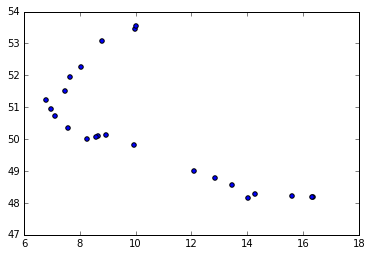

In [28]:
fig,ax = plt.subplots()
geo_df.plot(ax = ax)

In [32]:
#df_world_map = gpd.read_file(filename = 'simplified-land-polygons-complete-3857/simplified_land_polygons.shp')
df_world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


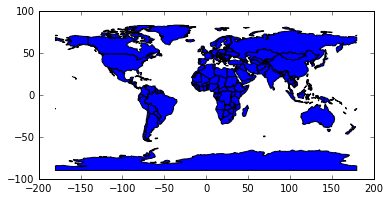

In [33]:
df_world_map.plot()

In [69]:
def plot_station_names(row,ax):
    
    point = row['geometry']
    coords = point.coords.xy
    
    x = coords[0][0]
    y = coords[1][0]
    
    name = '  %s' % row['name']
    
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
    
    ax.text(x,y,name,fontdict = font)
    

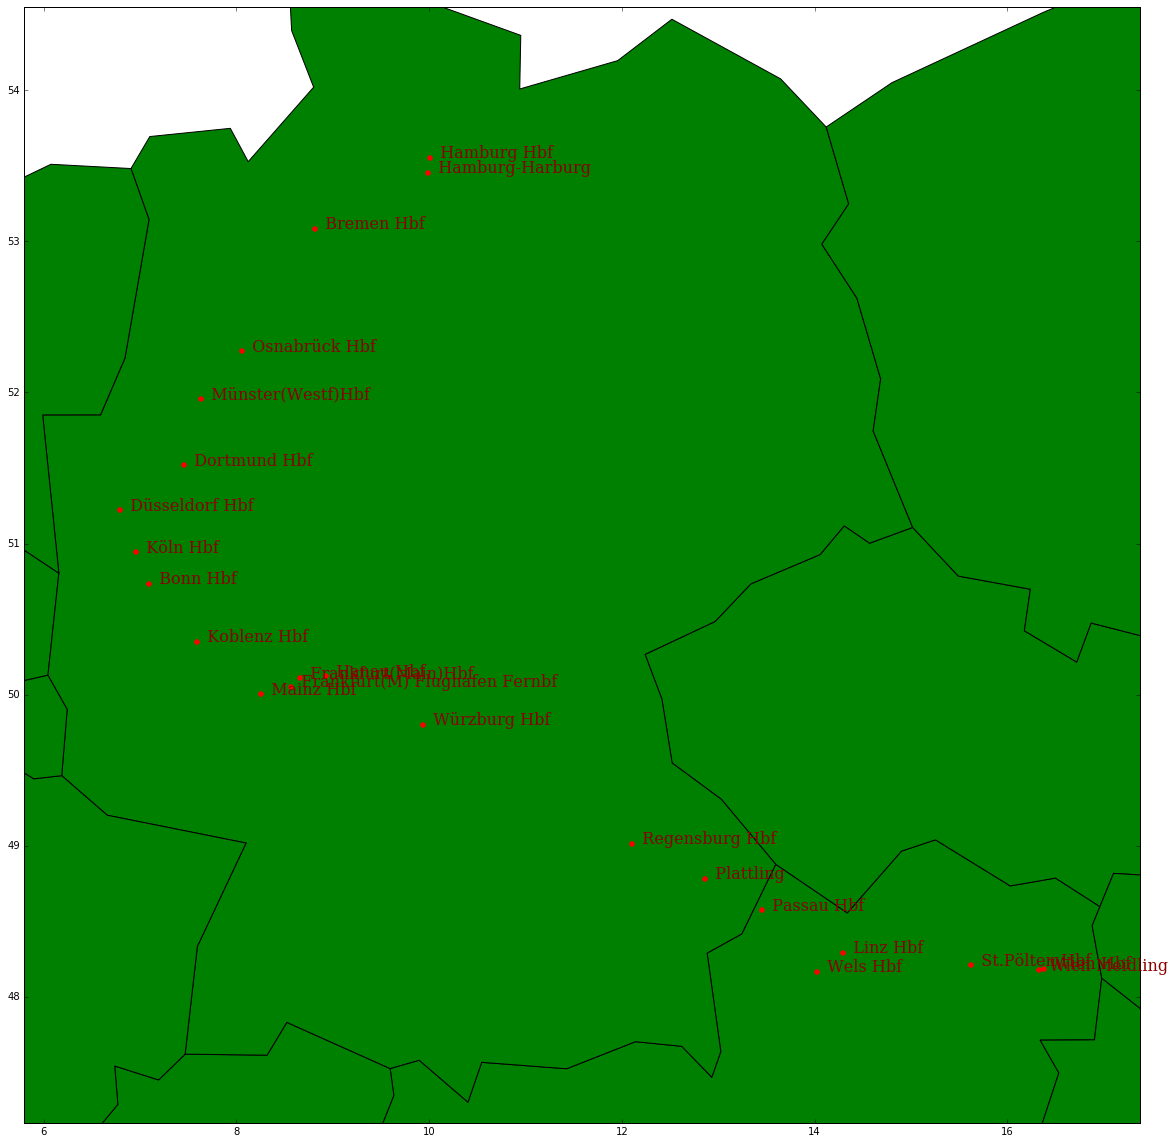

In [70]:
fig,ax = plt.subplots()

df_world_map.plot(ax = ax,color = 'green')
geo_df.plot(ax = ax,color = 'red')

geo_df.apply(func = plot_station_names,axis = 1,args = (ax,))

bounds = geo_df.geometry.bounds
a = ax.set_xlim([bounds.minx.min()-1, bounds.maxx.max()+1])
a = ax.set_ylim([bounds.miny.min()-1, bounds.maxy.max()+1])
